# Face Generation

In this project, you'll define and train a DCGAN on a dataset of faces. Your goal is to get a generator network to generate *new* images of faces that look as realistic as possible!

The project will be broken down into a series of tasks from **loading in data to defining and training adversarial networks**. At the end of the notebook, you'll be able to visualize the results of your trained Generator to see how it performs; your generated samples should look like fairly realistic faces with small amounts of noise.

### Get the Data

You'll be using the [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) to train your adversarial networks.

This dataset is more complex than the number datasets (like MNIST or SVHN) you've been working with, and so, you should prepare to define deeper networks and train them for a longer time to get good results. It is suggested that you utilize a GPU for training.

### Pre-processed Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. Some sample data is show below.

<img src='assets/processed_face_data.png' width=60% />

> If you are working locally, you can download this data [by clicking here](https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be7eb6f_processed-celeba-small/processed-celeba-small.zip)

This is a zip file that you'll need to extract in the home directory of this notebook for further loading and processing. After extracting the data, you should be left with a directory of data `processed_celeba_small/`

In [3]:
# can comment out after executing
!unzip processed_celeba_small.zip

'unzip' is not recognized as an internal or external command,
operable program or batch file.


In [4]:
data_dir = 'processed_celeba_small/'

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np
import problem_unittests as tests
#import helper

%matplotlib inline

## Visualize the CelebA Data

The [CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations. Since you're going to be generating faces, you won't need the annotations, you'll only need the images. Note that these are color images with [3 color channels (RGB)](https://en.wikipedia.org/wiki/Channel_(digital_image)#RGB_Images) each.

### Pre-process and Load the Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. This *pre-processed* dataset is a smaller subset of the very large CelebA data.

> There are a few other steps that you'll need to **transform** this data and create a **DataLoader**.

#### Exercise: Complete the following `get_dataloader` function, such that it satisfies these requirements:

* Your images should be square, Tensor images of size `image_size x image_size` in the x and y dimension.
* Your function should return a DataLoader that shuffles and batches these Tensor images.

#### ImageFolder

To create a dataset given a directory of images, it's recommended that you use PyTorch's [ImageFolder](https://pytorch.org/docs/stable/torchvision/datasets.html#imagefolder) wrapper, with a root directory `processed_celeba_small/` and data transformation passed in.

In [5]:
# necessary imports
import torch
from torchvision import datasets
from torchvision import transforms

In [6]:
def get_dataloader(batch_size, image_size, data_dir='processed_celeba_small/'):
    """
    Batch the neural network data using DataLoader
    :param batch_size: The size of each batch; the number of images in a batch
    :param img_size: The square size of the image data (x, y)
    :param data_dir: Directory where image data is located
    :return: DataLoader with batched data
    """
    

    transform = transforms.Compose([transforms.Resize(image_size), transforms.ToTensor()]) 
    
    # TODO: Implement function and return a dataloader
    dataset = datasets.ImageFolder(data_dir, transform=transform)
    loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
    return loader

## Create a DataLoader

#### Exercise: Create a DataLoader `celeba_train_loader` with appropriate hyperparameters.

Call the above function and create a dataloader to view images. 
* You can decide on any reasonable `batch_size` parameter
* Your `image_size` **must be** `32`. Resizing the data to a smaller size will make for faster training, while still creating convincing images of faces!

In [7]:
# Define function hyperparameters
batch_size = 32
img_size = 32

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# Call your function and get a dataloader
celeba_train_loader = get_dataloader(batch_size, img_size)


Next, you can view some images! You should seen square images of somewhat-centered faces.

Note: You'll need to convert the Tensor images into a NumPy type and transpose the dimensions to correctly display an image, suggested `imshow` code is below, but it may not be perfect.

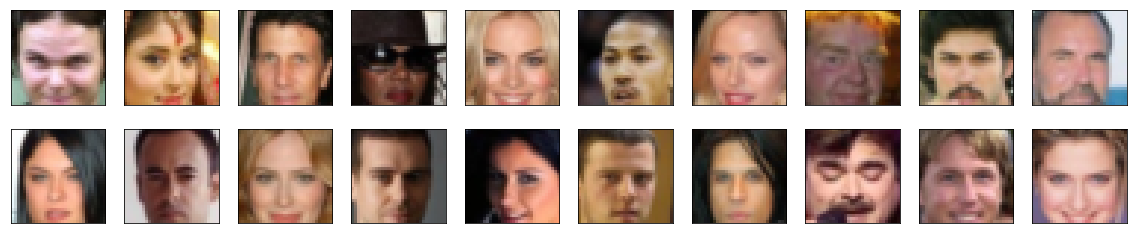

In [8]:
# helper display function
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# obtain one batch of training images
dataiter = iter(celeba_train_loader)
images, _ = dataiter.next() # _ for no labels

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 4))
plot_size=20
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, plot_size/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])

#### Exercise: Pre-process your image data and scale it to a pixel range of -1 to 1

You need to do a bit of pre-processing; you know that the output of a `tanh` activated generator will contain pixel values in a range from -1 to 1, and so, we need to rescale our training images to a range of -1 to 1. (Right now, they are in a range from 0-1.)

In [9]:
# TODO: Complete the scale function
def scale(x, feature_range=(-1, 1)):
    ''' Scale takes in an image x and returns that image, scaled
       with a feature_range of pixel values from -1 to 1. 
       This function assumes that the input x is already scaled from 0-1.'''
    # assume x is scaled to (0, 1)
    # scale to feature_range and return scaled x
    min, max = feature_range
    x = x * (max-min) + min
    return x

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# check scaled range
# should be close to -1 to 1
img = images[0]
scaled_img = scale(img)

print('Min: ', scaled_img.min())
print('Max: ', scaled_img.max())

Min:  tensor(-0.9765)
Max:  tensor(1.)


---
# Define the Model

A GAN is comprised of two adversarial networks, a discriminator and a generator.

## Discriminator

Your first task will be to define the discriminator. This is a convolutional classifier like you've built before, only without any maxpooling layers. To deal with this complex data, it's suggested you use a deep network with **normalization**. You are also allowed to create any helper functions that may be useful.

#### Exercise: Complete the Discriminator class
* The inputs to the discriminator are 32x32x3 tensor images
* The output should be a single value that will indicate whether a given image is real or fake


In [11]:
import torch.nn as nn
import torch.nn.functional as F

In [12]:
def conv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    layers = []
    conv_layer = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, 
                           kernel_size=kernel_size, stride=stride, padding=padding, bias=False) 
    
    layers.append(conv_layer)
    
    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
        
    return nn.Sequential(*layers)

In [13]:
class Discriminator(nn.Module):

    def __init__(self, conv_dim):
        """
        Initialize the Discriminator Module
        :param conv_dim: The depth of the first convolutional layer
        """
        super(Discriminator, self).__init__()

        # complete init function
        self.conv_dim = conv_dim
        self.conv1 = conv(3, conv_dim, 4, batch_norm=False)
        self.conv2 = conv(conv_dim, conv_dim*2, 4)
        self.conv3 = conv(conv_dim*2, conv_dim*4, 4)
        self.fc = nn.Linear(conv_dim*4*4*4,1)

    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: Discriminator logits; the output of the neural network
        """
        # define feedforward behavior
        x = F.leaky_relu(self.conv1(x), 0.2)
        x = F.leaky_relu(self.conv2(x), 0.2)
        x = F.leaky_relu(self.conv3(x), 0.2)
        
        x = x.view(-1, 4*4*4*self.conv_dim)
        x = self.fc(x)
        
        return x

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(Discriminator)

Tests Passed


## Generator

The generator should upsample an input and generate a *new* image of the same size as our training data `32x32x3`. This should be mostly transpose convolutional layers with normalization applied to the outputs.

#### Exercise: Complete the Generator class
* The inputs to the generator are vectors of some length `z_size`
* The output should be a image of shape `32x32x3`

In [14]:
def deconv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """Creates a transpose convolutional layer, with optional batch normalization.
    """
    layers = []
    # append transpose conv layer
    layers.append(nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=False))
    # optional batch norm layer
    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
    return nn.Sequential(*layers)

In [15]:
class Generator(nn.Module):
    
    def __init__(self, z_size, conv_dim):
        """
        Initialize the Generator Module
        :param z_size: The length of the input latent vector, z
        :param conv_dim: The depth of the inputs to the *last* transpose convolutional layer
        """
        super(Generator, self).__init__()

        # complete init function
        self.conv_dim = conv_dim
        self.fc = nn.Linear(z_size, conv_dim*4*4*4)
        self.t_conv1 = deconv(conv_dim*4, conv_dim*2, 4)
        self.t_conv2 = deconv(conv_dim*2, conv_dim, 4)
        self.t_conv3 = deconv(conv_dim, 3, 4, batch_norm=False)

    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: A 32x32x3 Tensor image as output
        """
        # define feedforward behavior
        x = self.fc(x)
        x = x.view(-1, self.conv_dim*4, 4, 4)
        x = F.relu(self.t_conv1(x))
        x = F.relu(self.t_conv2(x))
        x = self.t_conv3(x)
        x = torch.tanh(x)
        return x
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(Generator)

Tests Passed


## Initialize the weights of your networks

To help your models converge, you should initialize the weights of the convolutional and linear layers in your model. From reading the [original DCGAN paper](https://arxiv.org/pdf/1511.06434.pdf), they say:
> All weights were initialized from a zero-centered Normal distribution with standard deviation 0.02.

So, your next task will be to define a weight initialization function that does just this!

You can refer back to the lesson on weight initialization or even consult existing model code, such as that from [the `networks.py` file in CycleGAN Github repository](https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/blob/master/models/networks.py) to help you complete this function.

#### Exercise: Complete the weight initialization function

* This should initialize only **convolutional** and **linear** layers
* Initialize the weights to a normal distribution, centered around 0, with a standard deviation of 0.02.
* The bias terms, if they exist, may be left alone or set to 0.

In [16]:
def weights_init_normal(m):
    """
    Applies initial weights to certain layers in a model .
    The weights are taken from a normal distribution 
    with mean = 0, std dev = 0.02.
    :param m: A module or layer in a network    
    """
    # classname will be something like:
    # `Conv`, `BatchNorm2d`, `Linear`, etc.
    classname = m.__class__.__name__
    
    # TODO: Apply initial weights to convolutional and linear layers
    if hasattr(m, 'weight') and (classname.find('Conv') != -1 or classname.find('Linear') != -1):
        nn.init.normal_(m.weight.data, mean=0, std=0.02)
        
        if hasattr(m, 'bias') and m.bias is not None:
                nn.init.constant_(m.bias.data, 0.0)

## Build complete network

Define your models' hyperparameters and instantiate the discriminator and generator from the classes defined above. Make sure you've passed in the correct input arguments.

In [17]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
def build_network(d_conv_dim, g_conv_dim, z_size):
    # define discriminator and generator
    D = Discriminator(d_conv_dim)
    G = Generator(z_size=z_size, conv_dim=g_conv_dim)

    # initialize model weights
    D.apply(weights_init_normal)
    G.apply(weights_init_normal)

    print(D)
    print()
    print(G)
    
    return D, G


#### Exercise: Define model hyperparameters

In [18]:
# Define model hyperparams
d_conv_dim = 32
g_conv_dim = 32
z_size = 100

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
D, G = build_network(d_conv_dim, g_conv_dim, z_size)

Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc): Linear(in_features=2048, out_features=1, bias=True)
)

Generator(
  (fc): Linear(in_features=100, out_features=2048, bias=True)
  (t_conv1): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (t_conv2): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias

### Training on GPU

Check if you can train on GPU. Here, we'll set this as a boolean variable `train_on_gpu`. Later, you'll be responsible for making sure that 
>* Models,
* Model inputs, and
* Loss function arguments

Are moved to GPU, where appropriate.

In [19]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import torch

# Check for a GPU
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Training on GPU!')

Training on GPU!


---
## Discriminator and Generator Losses

Now we need to calculate the losses for both types of adversarial networks.

### Discriminator Losses

> * For the discriminator, the total loss is the sum of the losses for real and fake images, `d_loss = d_real_loss + d_fake_loss`. 
* Remember that we want the discriminator to output 1 for real images and 0 for fake images, so we need to set up the losses to reflect that.


### Generator Loss

The generator loss will look similar only with flipped labels. The generator's goal is to get the discriminator to *think* its generated images are *real*.

#### Exercise: Complete real and fake loss functions

**You may choose to use either cross entropy or a least squares error loss to complete the following `real_loss` and `fake_loss` functions.**

In [20]:
def real_loss(D_out):
    '''Calculates how close discriminator outputs are to being real.
       param, D_out: discriminator logits
       return: real loss'''
    batch_size = D_out.size(0)
    labels = torch.ones(batch_size)
    if train_on_gpu:
        labels = labels.cuda()
    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(D_out.squeeze(), labels)
    return loss


def fake_loss(D_out):
    '''Calculates how close discriminator outputs are to being fake.
       param, D_out: discriminator logits
       return: fake loss'''
    batch_size = D_out.size(0)
    labels = torch.zeros(batch_size)
    if train_on_gpu:
        labels = labels.cuda()
    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(D_out.squeeze(), labels)
    return loss

## Optimizers

#### Exercise: Define optimizers for your Discriminator (D) and Generator (G)

Define optimizers for your models with appropriate hyperparameters.

In [21]:
import torch.optim as optim

lr=0.0002
beta1=0.5
beta2=0.999
# Create optimizers for the discriminator D and generator G
d_optimizer = optim.Adam(D.parameters(), lr, [beta1, beta2])
g_optimizer = optim.Adam(G.parameters(), lr, [beta1, beta2])

---
## Training

Training will involve alternating between training the discriminator and the generator. You'll use your functions `real_loss` and `fake_loss` to help you calculate the discriminator losses.

* You should train the discriminator by alternating on real and fake images
* Then the generator, which tries to trick the discriminator and should have an opposing loss function


#### Saving Samples

You've been given some code to print out some loss statistics and save some generated "fake" samples.

#### Exercise: Complete the training function

Keep in mind that, if you've moved your models to GPU, you'll also have to move any model inputs to GPU.

In [22]:
def train(D, G, n_epochs, print_every=50):
    '''Trains adversarial networks for some number of epochs
       param, D: the discriminator network
       param, G: the generator network
       param, n_epochs: number of epochs to train for
       param, print_every: when to print and record the models' losses
       return: D and G losses'''
    
    # move models to GPU
    if train_on_gpu:
        D.cuda()
        G.cuda()

    # keep track of loss and generated, "fake" samples
    samples = []
    losses = []

    # Get some fixed data for sampling. These are images that are held
    # constant throughout training, and allow us to inspect the model's performance
    sample_size=16
    fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
    fixed_z = torch.from_numpy(fixed_z).float()
    # move z to GPU if available
    if train_on_gpu:
        fixed_z = fixed_z.cuda()

    # epoch training loop
    for epoch in range(n_epochs):

        # batch training loop
        for batch_i, (real_images, _) in enumerate(celeba_train_loader):

            batch_size = real_images.size(0)
            real_images = scale(real_images)

            # ===============================================
            #         YOUR CODE HERE: TRAIN THE NETWORKS
            # ===============================================
            
            # 1. Train the discriminator on real and fake images
            d_optimizer.zero_grad()
            if train_on_gpu:
                real_images = real_images.cuda()
            D_real = D(real_images)
            d_real_loss = real_loss(D_real)
            
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            if train_on_gpu:
                z = z.cuda()
            fake_images = G(z)
            D_fake = D(fake_images)
            d_fake_loss = fake_loss(D_fake)
            
            d_loss = d_real_loss + d_fake_loss
            d_loss.backward()
            d_optimizer.step()

            # 2. Train the generator with an adversarial loss
            g_optimizer.zero_grad()
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            if train_on_gpu:
                z = z.cuda()
            fake_images = G(z)
            D_fake = D(fake_images)

            g_loss = real_loss(D_fake)
            g_loss.backward()
            g_optimizer.step()
            
            
            # ===============================================
            #              END OF YOUR CODE
            # ===============================================

            # Print some loss stats
            if batch_i % print_every == 0:
                # append discriminator loss and generator loss
                losses.append((d_loss.item(), g_loss.item()))
                # print discriminator and generator loss
                print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                        epoch+1, n_epochs, d_loss.item(), g_loss.item()))


        ## AFTER EACH EPOCH##    
        # this code assumes your generator is named G, feel free to change the name
        # generate and save sample, fake images
        G.eval() # for generating samples
        samples_z = G(fixed_z)
        samples.append(samples_z)
        G.train() # back to training mode

    # Save training generator samples
    with open('train_samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    # finally return losses
    return losses

Set your number of training epochs and train your GAN!

In [34]:
# set number of epochs 
n_epochs = 25


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
# call training function
losses = train(D, G, n_epochs=n_epochs)

Epoch [    1/   25] | d_loss: 0.0176 | g_loss: 5.2497
Epoch [    1/   25] | d_loss: 0.6692 | g_loss: 1.5859
Epoch [    1/   25] | d_loss: 0.0653 | g_loss: 6.7745
Epoch [    1/   25] | d_loss: 0.0723 | g_loss: 4.4971
Epoch [    1/   25] | d_loss: 0.0517 | g_loss: 5.8861
Epoch [    1/   25] | d_loss: 0.0955 | g_loss: 7.0051
Epoch [    1/   25] | d_loss: 0.1361 | g_loss: 3.7004
Epoch [    1/   25] | d_loss: 0.0649 | g_loss: 6.1775
Epoch [    1/   25] | d_loss: 0.0520 | g_loss: 4.5413
Epoch [    1/   25] | d_loss: 0.0658 | g_loss: 3.1806
Epoch [    1/   25] | d_loss: 0.1105 | g_loss: 4.2625
Epoch [    1/   25] | d_loss: 0.1008 | g_loss: 5.4479
Epoch [    1/   25] | d_loss: 0.0830 | g_loss: 3.4093
Epoch [    1/   25] | d_loss: 0.0258 | g_loss: 4.5240
Epoch [    1/   25] | d_loss: 0.1798 | g_loss: 4.8430
Epoch [    1/   25] | d_loss: 0.0128 | g_loss: 5.5835
Epoch [    1/   25] | d_loss: 0.0718 | g_loss: 7.1975
Epoch [    1/   25] | d_loss: 0.0167 | g_loss: 6.1021
Epoch [    1/   25] | d_loss

Epoch [    3/   25] | d_loss: 0.0989 | g_loss: 5.8944
Epoch [    3/   25] | d_loss: 0.0511 | g_loss: 1.4134
Epoch [    3/   25] | d_loss: 0.0163 | g_loss: 5.6186
Epoch [    3/   25] | d_loss: 1.4545 | g_loss: 1.6172
Epoch [    3/   25] | d_loss: 0.0385 | g_loss: 6.3679
Epoch [    3/   25] | d_loss: 0.0668 | g_loss: 3.8295
Epoch [    3/   25] | d_loss: 0.0392 | g_loss: 2.7436
Epoch [    3/   25] | d_loss: 0.0669 | g_loss: 4.9633
Epoch [    3/   25] | d_loss: 0.0410 | g_loss: 5.8773
Epoch [    3/   25] | d_loss: 0.2143 | g_loss: 5.2665
Epoch [    3/   25] | d_loss: 0.2014 | g_loss: 5.7547
Epoch [    3/   25] | d_loss: 0.0418 | g_loss: 5.3430
Epoch [    3/   25] | d_loss: 0.0243 | g_loss: 6.5459
Epoch [    3/   25] | d_loss: 0.0525 | g_loss: 5.4969
Epoch [    3/   25] | d_loss: 0.0207 | g_loss: 5.7265
Epoch [    3/   25] | d_loss: 0.0860 | g_loss: 5.0384
Epoch [    3/   25] | d_loss: 0.0151 | g_loss: 6.3843
Epoch [    3/   25] | d_loss: 0.2980 | g_loss: 5.1544
Epoch [    3/   25] | d_loss

Epoch [    6/   25] | d_loss: 0.0235 | g_loss: 7.0647
Epoch [    6/   25] | d_loss: 0.1423 | g_loss: 5.6761
Epoch [    6/   25] | d_loss: 0.0415 | g_loss: 6.4765
Epoch [    6/   25] | d_loss: 0.0823 | g_loss: 5.8054
Epoch [    6/   25] | d_loss: 0.0223 | g_loss: 7.1616
Epoch [    6/   25] | d_loss: 0.0088 | g_loss: 5.0471
Epoch [    6/   25] | d_loss: 0.0117 | g_loss: 6.7287
Epoch [    6/   25] | d_loss: 0.0662 | g_loss: 5.6371
Epoch [    6/   25] | d_loss: 0.0648 | g_loss: 4.0474
Epoch [    6/   25] | d_loss: 0.0311 | g_loss: 6.1496
Epoch [    6/   25] | d_loss: 0.0145 | g_loss: 5.6250
Epoch [    6/   25] | d_loss: 0.0291 | g_loss: 8.3042
Epoch [    6/   25] | d_loss: 0.0102 | g_loss: 6.3523
Epoch [    6/   25] | d_loss: 0.0075 | g_loss: 8.8617
Epoch [    6/   25] | d_loss: 0.0085 | g_loss: 7.9965
Epoch [    6/   25] | d_loss: 0.0023 | g_loss: 6.5132
Epoch [    6/   25] | d_loss: 0.0017 | g_loss: 8.6704
Epoch [    6/   25] | d_loss: 0.0040 | g_loss: 8.7797
Epoch [    6/   25] | d_loss

Epoch [    8/   25] | d_loss: 0.0302 | g_loss: 6.9574
Epoch [    8/   25] | d_loss: 0.0010 | g_loss: 21.5842
Epoch [    8/   25] | d_loss: 1.2071 | g_loss: 7.6641
Epoch [    9/   25] | d_loss: 0.0079 | g_loss: 9.8580
Epoch [    9/   25] | d_loss: 0.0487 | g_loss: 14.5458
Epoch [    9/   25] | d_loss: 0.0532 | g_loss: 7.8039
Epoch [    9/   25] | d_loss: 0.0108 | g_loss: 11.2385
Epoch [    9/   25] | d_loss: 0.0367 | g_loss: 21.4035
Epoch [    9/   25] | d_loss: 0.0078 | g_loss: 6.7876
Epoch [    9/   25] | d_loss: 0.0010 | g_loss: 10.1795
Epoch [    9/   25] | d_loss: 0.0100 | g_loss: 5.9645
Epoch [    9/   25] | d_loss: 0.0060 | g_loss: 7.3326
Epoch [    9/   25] | d_loss: 0.0210 | g_loss: 7.8052
Epoch [    9/   25] | d_loss: 0.1168 | g_loss: 4.1061
Epoch [    9/   25] | d_loss: 0.0029 | g_loss: 9.8523
Epoch [    9/   25] | d_loss: 0.0027 | g_loss: 6.7857
Epoch [    9/   25] | d_loss: 0.0521 | g_loss: 6.1632
Epoch [    9/   25] | d_loss: 0.0072 | g_loss: 6.0618
Epoch [    9/   25] | d

Epoch [   11/   25] | d_loss: 0.0195 | g_loss: 8.4485
Epoch [   11/   25] | d_loss: 0.0020 | g_loss: 10.9773
Epoch [   11/   25] | d_loss: 0.1288 | g_loss: 6.1315
Epoch [   11/   25] | d_loss: 0.0525 | g_loss: 8.6056
Epoch [   11/   25] | d_loss: 0.1207 | g_loss: 11.9257
Epoch [   11/   25] | d_loss: 0.0601 | g_loss: 9.3460
Epoch [   11/   25] | d_loss: 0.0761 | g_loss: 6.2631
Epoch [   11/   25] | d_loss: 0.0219 | g_loss: 8.0387
Epoch [   11/   25] | d_loss: 0.0203 | g_loss: 11.9473
Epoch [   11/   25] | d_loss: 0.0124 | g_loss: 11.7444
Epoch [   11/   25] | d_loss: 0.0010 | g_loss: 12.1595
Epoch [   11/   25] | d_loss: 0.0947 | g_loss: 9.8390
Epoch [   11/   25] | d_loss: 0.0058 | g_loss: 8.8017
Epoch [   11/   25] | d_loss: 0.0024 | g_loss: 7.4479
Epoch [   11/   25] | d_loss: 0.0052 | g_loss: 13.3980
Epoch [   11/   25] | d_loss: 0.1038 | g_loss: 5.0793
Epoch [   11/   25] | d_loss: 0.0215 | g_loss: 6.8117
Epoch [   11/   25] | d_loss: 0.0326 | g_loss: 6.3678
Epoch [   11/   25] | 

Epoch [   14/   25] | d_loss: 0.0403 | g_loss: 12.9693
Epoch [   14/   25] | d_loss: 0.0720 | g_loss: 7.0651
Epoch [   14/   25] | d_loss: 0.0348 | g_loss: 6.7078
Epoch [   14/   25] | d_loss: 0.1930 | g_loss: 5.0867
Epoch [   14/   25] | d_loss: 0.1375 | g_loss: 9.0826
Epoch [   14/   25] | d_loss: 0.0950 | g_loss: 7.1203
Epoch [   14/   25] | d_loss: 0.0117 | g_loss: 6.2653
Epoch [   14/   25] | d_loss: 0.0171 | g_loss: 5.1792
Epoch [   14/   25] | d_loss: 0.0046 | g_loss: 6.8487
Epoch [   14/   25] | d_loss: 0.0066 | g_loss: 8.1812
Epoch [   14/   25] | d_loss: 0.0068 | g_loss: 20.4777
Epoch [   14/   25] | d_loss: 0.0560 | g_loss: 6.1096
Epoch [   14/   25] | d_loss: 0.0012 | g_loss: 9.3698
Epoch [   14/   25] | d_loss: 0.2601 | g_loss: 3.7326
Epoch [   14/   25] | d_loss: 0.0186 | g_loss: 9.2752
Epoch [   14/   25] | d_loss: 0.0007 | g_loss: 7.0900
Epoch [   14/   25] | d_loss: 0.0176 | g_loss: 7.5501
Epoch [   14/   25] | d_loss: 0.0008 | g_loss: 8.9654
Epoch [   14/   25] | d_lo

Epoch [   16/   25] | d_loss: 0.0520 | g_loss: 10.8171
Epoch [   16/   25] | d_loss: 0.0123 | g_loss: 10.4583
Epoch [   16/   25] | d_loss: 0.6890 | g_loss: 18.8429
Epoch [   16/   25] | d_loss: 0.0185 | g_loss: 10.9167
Epoch [   16/   25] | d_loss: 0.0014 | g_loss: 8.4314
Epoch [   16/   25] | d_loss: 0.0001 | g_loss: 9.7099
Epoch [   16/   25] | d_loss: 0.0366 | g_loss: 5.8554
Epoch [   17/   25] | d_loss: 0.0174 | g_loss: 10.0976
Epoch [   17/   25] | d_loss: 0.0094 | g_loss: 7.0606
Epoch [   17/   25] | d_loss: 0.0028 | g_loss: 9.4186
Epoch [   17/   25] | d_loss: 0.4564 | g_loss: 8.2994
Epoch [   17/   25] | d_loss: 0.0165 | g_loss: 7.7235
Epoch [   17/   25] | d_loss: 1.9722 | g_loss: 3.1327
Epoch [   17/   25] | d_loss: 0.0119 | g_loss: 6.3703
Epoch [   17/   25] | d_loss: 0.0419 | g_loss: 7.5138
Epoch [   17/   25] | d_loss: 0.0018 | g_loss: 11.8704
Epoch [   17/   25] | d_loss: 0.0071 | g_loss: 10.3047
Epoch [   17/   25] | d_loss: 0.0592 | g_loss: 7.2949
Epoch [   17/   25] |

Epoch [   19/   25] | d_loss: 0.0380 | g_loss: 9.5797
Epoch [   19/   25] | d_loss: 0.0147 | g_loss: 7.4199
Epoch [   19/   25] | d_loss: 0.0173 | g_loss: 7.6012
Epoch [   19/   25] | d_loss: 0.0340 | g_loss: 4.4497
Epoch [   19/   25] | d_loss: 0.0617 | g_loss: 8.2238
Epoch [   19/   25] | d_loss: 0.0303 | g_loss: 5.9775
Epoch [   19/   25] | d_loss: 0.0489 | g_loss: 9.1337
Epoch [   19/   25] | d_loss: 0.0095 | g_loss: 7.1080
Epoch [   19/   25] | d_loss: 0.0320 | g_loss: 6.0189
Epoch [   19/   25] | d_loss: 0.0048 | g_loss: 11.5537
Epoch [   19/   25] | d_loss: 0.0045 | g_loss: 6.6706
Epoch [   19/   25] | d_loss: 0.0049 | g_loss: 8.2774
Epoch [   19/   25] | d_loss: 0.0967 | g_loss: 7.5815
Epoch [   19/   25] | d_loss: 0.0076 | g_loss: 7.7139
Epoch [   19/   25] | d_loss: 0.0509 | g_loss: 6.8805
Epoch [   19/   25] | d_loss: 0.0050 | g_loss: 11.0699
Epoch [   19/   25] | d_loss: 0.0214 | g_loss: 6.2580
Epoch [   19/   25] | d_loss: 0.0271 | g_loss: 7.1915
Epoch [   19/   25] | d_lo

Epoch [   22/   25] | d_loss: 0.0487 | g_loss: 6.3068
Epoch [   22/   25] | d_loss: 0.0670 | g_loss: 7.7543
Epoch [   22/   25] | d_loss: 0.1989 | g_loss: 11.4919
Epoch [   22/   25] | d_loss: 0.0442 | g_loss: 7.7637
Epoch [   22/   25] | d_loss: 0.0041 | g_loss: 9.3888
Epoch [   22/   25] | d_loss: 0.0081 | g_loss: 8.5383
Epoch [   22/   25] | d_loss: 0.1453 | g_loss: 5.1089
Epoch [   22/   25] | d_loss: 0.0481 | g_loss: 4.7168
Epoch [   22/   25] | d_loss: 0.0036 | g_loss: 8.5914
Epoch [   22/   25] | d_loss: 0.0271 | g_loss: 8.2210
Epoch [   22/   25] | d_loss: 0.0109 | g_loss: 4.7106
Epoch [   22/   25] | d_loss: 0.1647 | g_loss: 10.0912
Epoch [   22/   25] | d_loss: 0.0229 | g_loss: 7.5279
Epoch [   22/   25] | d_loss: 0.1060 | g_loss: 4.1155
Epoch [   22/   25] | d_loss: 0.0031 | g_loss: 11.7372
Epoch [   22/   25] | d_loss: 0.0525 | g_loss: 7.8384
Epoch [   22/   25] | d_loss: 0.0246 | g_loss: 7.8707
Epoch [   22/   25] | d_loss: 0.0441 | g_loss: 7.1005
Epoch [   22/   25] | d_l

Epoch [   24/   25] | d_loss: 0.0254 | g_loss: 8.4508
Epoch [   24/   25] | d_loss: 0.0559 | g_loss: 7.1044
Epoch [   24/   25] | d_loss: 0.0019 | g_loss: 9.2024
Epoch [   24/   25] | d_loss: 0.0092 | g_loss: 6.8905
Epoch [   24/   25] | d_loss: 0.0116 | g_loss: 6.4891
Epoch [   24/   25] | d_loss: 0.0111 | g_loss: 9.0776
Epoch [   24/   25] | d_loss: 0.0260 | g_loss: 4.8991
Epoch [   24/   25] | d_loss: 0.0059 | g_loss: 11.8695
Epoch [   24/   25] | d_loss: 0.0060 | g_loss: 6.5815
Epoch [   24/   25] | d_loss: 0.0661 | g_loss: 3.3186
Epoch [   25/   25] | d_loss: 0.0407 | g_loss: 7.1877
Epoch [   25/   25] | d_loss: 0.0431 | g_loss: 7.0119
Epoch [   25/   25] | d_loss: 0.0635 | g_loss: 8.1320
Epoch [   25/   25] | d_loss: 0.1166 | g_loss: 5.2512
Epoch [   25/   25] | d_loss: 0.0307 | g_loss: 8.7953
Epoch [   25/   25] | d_loss: 0.0114 | g_loss: 6.7786
Epoch [   25/   25] | d_loss: 0.0210 | g_loss: 5.9162
Epoch [   25/   25] | d_loss: 0.0189 | g_loss: 7.0675
Epoch [   25/   25] | d_los

## Training loss

Plot the training losses for the generator and discriminator, recorded after each epoch.

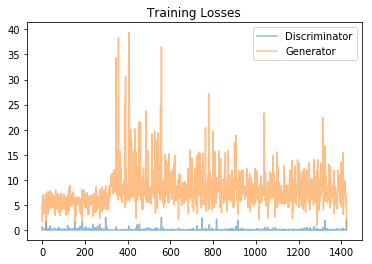

In [35]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

## Generator samples from training

View samples of images from the generator, and answer a question about the strengths and weaknesses of your trained models.

In [36]:
# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(16,4), nrows=2, ncols=8, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img + 1)*255 / (2)).astype(np.uint8)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((32,32,3)))

In [37]:
# Load samples from generator, taken while training
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

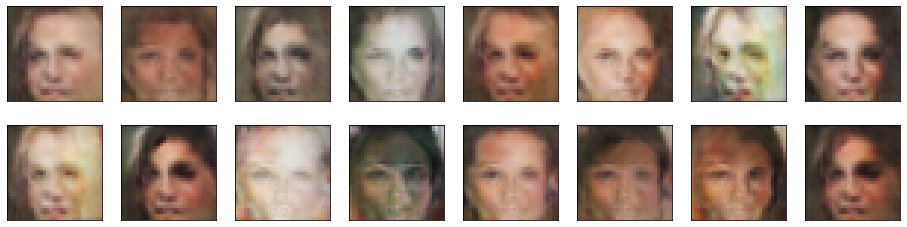

In [38]:
_ = view_samples(-1, samples)

### Question: What do you notice about your generated samples and how might you improve this model?
When you answer this question, consider the following factors:
* The dataset is biased; it is made of "celebrity" faces that are mostly white
* Model size; larger models have the opportunity to learn more features in a data feature space
* Optimization strategy; optimizers and number of epochs affect your final result


**Answer:** 

1.The dataset has some asian images and yes alot of mostly white pictures.  For better results a dataset with a specific race would yield better results or alot more of celebrities from the eastern part of the world. The dataset had a good amount of pictures that had celebrities with glasses and/or hats that through off some of the faces generated.

2.By adding more layers and another fully connected layer we would see better results in training.

3.The Adam optimizer was used because it gives better results faster. The image was downsized from 64 by 64 to 32 by 32 to decrease training time. One training cycle of 40 epochs I had generated a celebrity with half of the glasses on the face. I then retrained lowering the epochs to see different results with 20 epochs this gave lower quality generations of faces. Increasing the epochs just a little bit made a whole lot of difference in getting final results.  

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "problem_unittests.py" files in your submission.